In [1]:
# import sys
# !{sys.executable} -m pip install seaborn

In [2]:
# libs
import os

import psycopg
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import mlflow
from dotenv import load_dotenv

load_dotenv()

/home/mle-user/.local/lib/python3.10/site-packages/pydantic/_internal/_fields.py:149: UserWarning: Field "model_server_url" has conflict with protected namespace "model_".

You may be able to resolve this warning by setting `model_config['protected_namespaces'] = ()`.
  warnings.warn(
/home/mle-user/.local/lib/python3.10/site-packages/pydantic/_internal/_config.py:321: UserWarning: Valid config keys have changed in V2:
* 'schema_extra' has been renamed to 'json_schema_extra'
  warnings.warn(message, UserWarning)


True

In [3]:
# settings

TABLE_NAME = "users_churn" # таблица с данными в postgres 

TRACKING_SERVER_HOST = "127.0.0.1"
TRACKING_SERVER_PORT = 5000

EXPERIMENT_NAME = "eda_churn_alexndem" # напишите название вашего эксперимента
RUN_NAME = "eda"

ASSETS_DIR = "assets"

os.makedirs(ASSETS_DIR, exist_ok=True) # или os.makedirs(ASSETS_DIR, exist_ok=True)

pd.options.display.max_columns = 100
pd.options.display.max_rows = 64

sns.set_style("white")
sns.set_theme(style="whitegrid") 

### Загрузка данных

In [4]:
connection = {"sslmode": "require", "target_session_attrs": "read-write"}
postgres_credentials = {
    "host": os.getenv("DB_DESTINATION_HOST"),
    "port": os.getenv("DB_DESTINATION_PORT"),
    "dbname": os.getenv("DB_DESTINATION_NAME"),
    "user": os.getenv("DB_DESTINATION_USER"),
    "password": os.getenv("DB_DESTINATION_PASSWORD"),
}

connection.update(postgres_credentials)

with psycopg.connect(**connection) as conn:

    with conn.cursor() as cur:
        cur.execute(f"SELECT * FROM {TABLE_NAME}")
        data = cur.fetchall()
        columns = [col[0] for col in cur.description]

df = pd.DataFrame(data, columns=columns)

df.head(2) 

,id,customer_id,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,gender,streaming_movies,senior_citizen,partner,dependents,multiple_lines,target
0,1,7590-VHVEG,2020-01-01,NaT,Month-to-month,Yes,Electronic check,29.85,29.85,DSL,No,Yes,No,No,No,Female,No,0,Yes,No,None,0
1,2,5575-GNVDE,2017-04-01,NaT,One year,No,Mailed check,56.95,1889.50,DSL,Yes,No,Yes,No,No,Male,No,0,No,No,No,0


### Распределение пользователей

/tmp/ipykernel_6741/3237920762.py:13: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[0, 0].set_xticklabels(df[x].unique(), rotation = 45)
/tmp/ipykernel_6741/3237920762.py:22: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[1, 0].set_xticklabels(df[x].unique(), rotation = 45)
/tmp/ipykernel_6741/3237920762.py:31: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[0, 1].set_xticklabels(df[x].unique(), rotation = 45)
/tmp/ipykernel_6741/3237920762.py:41: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[1, 1].set_xticklabels(df[x].unique(), rotation = 45)


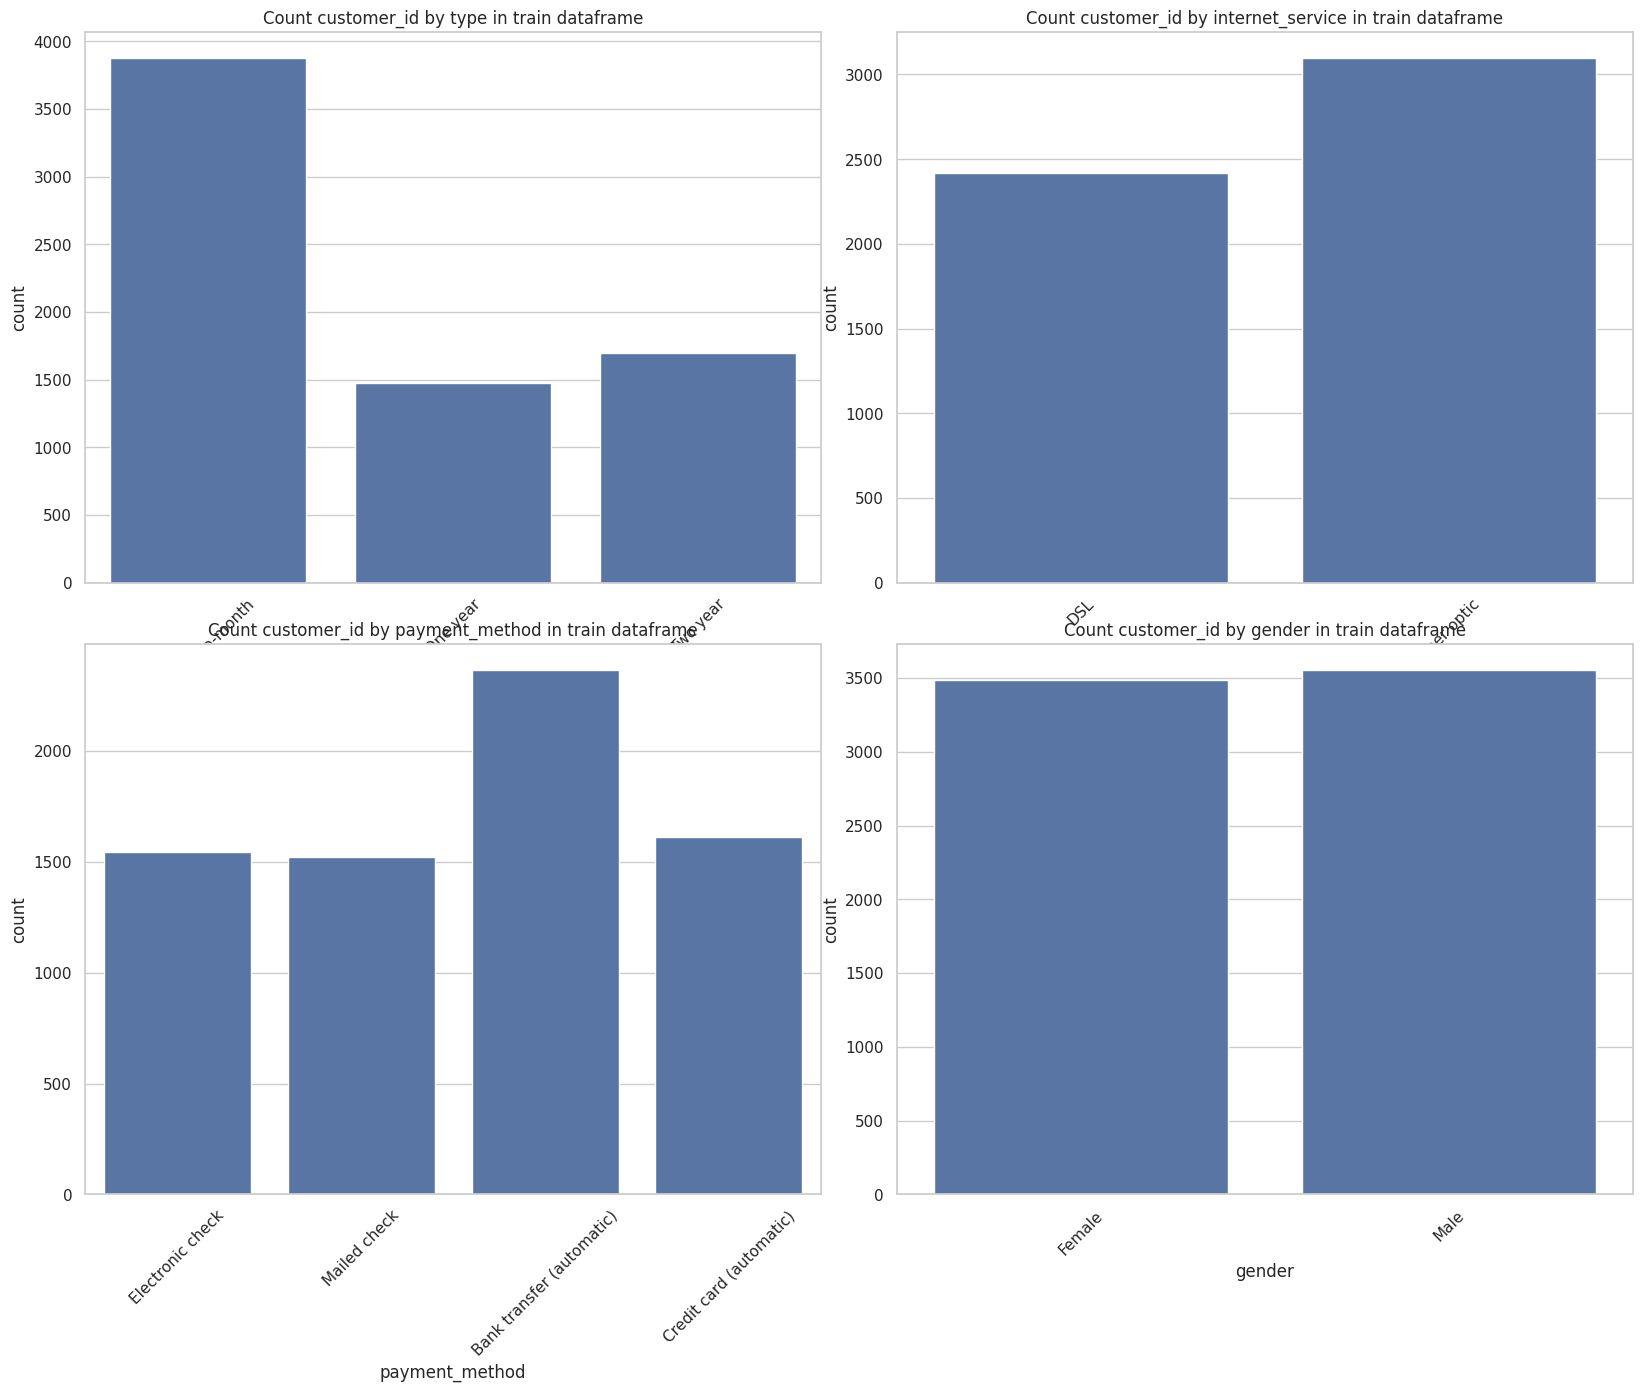

<Figure size 640x480 with 0 Axes>

In [49]:
fig, axs = plt.subplots(2, 2)
fig.set_size_inches(16.5, 12.5, forward=True)
fig.tight_layout(pad=1.6)


x = "type"
y = "customer_id"
stat = ["count"]
agg_df = df.groupby(x).agg({y: stat[0]}).reset_index()
agg_df = agg_df.rename(columns={y: stat[0]})
sns.barplot(data=agg_df, x=x, y=stat[0], ax=axs[0, 0])
axs[0, 0].set_title(f'Count {y} by {x} in train dataframe')
axs[0, 0].set_xticklabels(df[x].unique(), rotation = 45)

x = "payment_method"
y = "customer_id"
stat = ["count"]
agg_df = df.groupby(x).agg({y: stat[0]}).reset_index()
agg_df = agg_df.rename(columns={y: stat[0]})
sns.barplot(x=x, y=stat[0], data=agg_df, ax=axs[1, 0])
axs[1, 0].set_title(f'Count {y} by {x} in train dataframe')
axs[1, 0].set_xticklabels(df[x].unique(), rotation = 45)

x = "internet_service"
y = "customer_id"
stat = ["count"]
agg_df = df.groupby(x).agg({y: stat[0]}).reset_index()
agg_df = agg_df.rename(columns={y: stat[0]})
sns.barplot(x=x, y=stat[0], data=agg_df, ax=axs[0, 1])
axs[0, 1].set_title(f'Count {y} by {x} in train dataframe')
axs[0, 1].set_xticklabels(df[x].unique(), rotation = 45)


x = "gender"
y = "customer_id"
stat = ["count"]
agg_df = df.groupby(x).agg({y: stat[0]}).reset_index()
agg_df = agg_df.rename(columns={y: stat[0]})
sns.barplot(x=x, y=stat[0], data=agg_df, ax=axs[1, 1])
axs[1, 1].set_title(f'Count {y} by {x} in train dataframe')
axs[1, 1].set_xticklabels(df[x].unique(), rotation = 45)

plt.show()
plt.savefig(os.path.join(ASSETS_DIR, "users_distribution.png"))

### Бинарные признаки

In [9]:
x = "customer_id"

binary_columns = [
    "online_security", 
    "online_backup", 
    "device_protection", 
    "tech_support",
    "streaming_tv",
    "streaming_movies",
    "senior_citizen",
    "partner",
    "dependents",
]
stat = ['count']

print(df.groupby(binary_columns).agg(stat[0])[x].reset_index().sort_values(by=x, ascending=False).head(10))

    online_security online_backup device_protection tech_support streaming_tv  \
0                No            No                No           No           No   
106              No           Yes                No           No           No   
414             Yes           Yes               Yes          Yes          Yes   
4                No            No                No           No           No   
8                No            No                No           No           No   
15               No            No                No           No          Yes   
214             Yes            No                No           No           No   
22               No            No                No           No          Yes   
413             Yes           Yes               Yes          Yes          Yes   
3                No            No                No           No           No   

    streaming_movies  senior_citizen partner dependents  customer_id  
0                 No               0 

In [14]:
df['senior_citizen'] = df['senior_citizen'].map({1: 'Yes', 0: 'No'})

<Axes: >

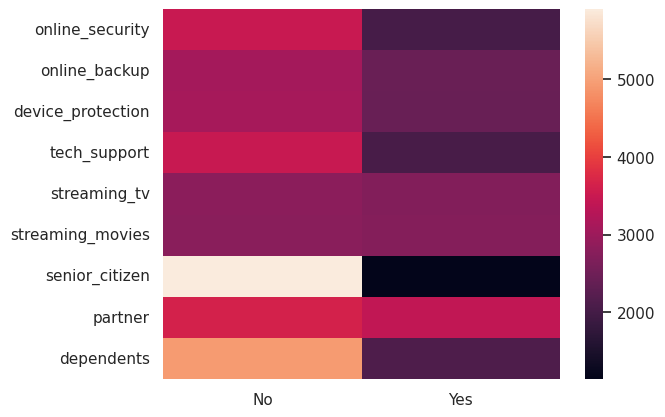

In [15]:
heat_df = df[binary_columns].apply(pd.Series.value_counts).T
sns.heatmap(heat_df) # ваш код здесь

### Числовые признаки

In [16]:
# инициализация переменной для названия колонки
x = "begin_date"

# список колонок, для которых будут вычисляться статистики
charges_columns = [
    "monthly_charges",
    "total_charges",
]

# удаление пустых колонок для посчёта медианного значения
df.dropna(subset=charges_columns, how='any', inplace=True)

# список статистик, которые будут вычисляться для каждой группы
stats = ["mean", "median", lambda x: x.mode().iloc[0]]  # среднее значение, медиана и мода

In [29]:
charges_columns

['monthly_charges', 'total_charges']

In [30]:
x

'begin_date'

In [32]:
# группировка данных по дате начала и агрегация статистик для ежемесячных платежей (используйте reset_index для сброса индекса в таблице)
charges_monthly_agg = df[[x] + [charges_columns[0]]].groupby([x]).agg(stats).reset_index()
# удаление верхнего уровня индекса колонок (после агрегации)
charges_monthly_agg.columns = charges_monthly_agg.columns.droplevel()
# переименование колонок для удобства восприятия
charges_monthly_agg.columns = [x, "monthly_mean", "monthly_median", "monthly_mode"]

In [21]:
# аналогично для общих платежей
charges_total_agg = df[[x] + [charges_columns[1]]].groupby([x]).agg(stats).reset_index()
charges_total_agg.columns = charges_total_agg.columns.droplevel()
charges_total_agg.columns = [x, "total_mean", "total_median", "total_mode"]

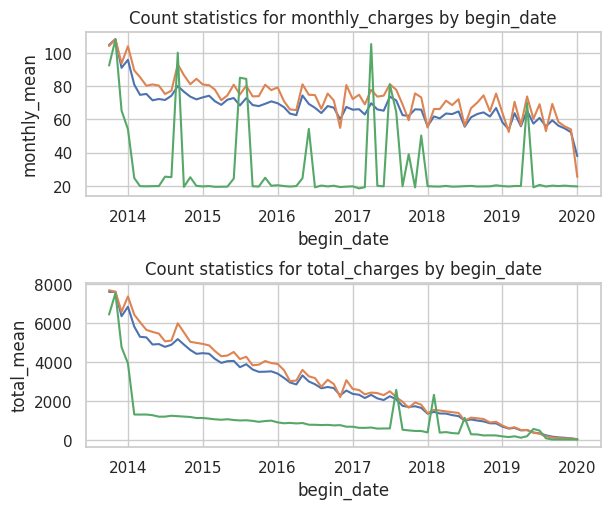

<Figure size 640x480 with 0 Axes>

In [34]:
# создание объекта для отображения графиков (2 графика вертикально)
fig, axs = plt.subplots(2, 1)
# настройка отступов между графиками
fig.tight_layout(pad=2.5)
# установка размера фигуры
fig.set_size_inches(6.5, 5.5, forward=True)

# построение линейных графиков для ежемесячных платежей
sns.lineplot(data=charges_monthly_agg, x=x, y="monthly_mean", ax=axs[0])
sns.lineplot(data=charges_monthly_agg, x=x, y="monthly_median", ax=axs[0])
sns.lineplot(data=charges_monthly_agg, x=x, y="monthly_mode", ax=axs[0])
# установка заголовка для верхнего графика
axs[0].set_title(f"Count statistics for {charges_columns[0]} by {x}")

# построение линейных графиков для общих платежей
sns.lineplot(data=charges_total_agg, x=x, y="total_mean", ax=axs[1])
sns.lineplot(data=charges_total_agg, x=x, y="total_median", ax=axs[1])
sns.lineplot(data=charges_total_agg, x=x, y="total_mode", ax=axs[1])
# установка заголовка для нижнего графика
axs[1].set_title(f"Count statistics for {charges_columns[1]} by {x}")

# сохранение графика в файл
plt.show()
plt.savefig(os.path.join(ASSETS_DIR, "charges_by_date.png"))

In [27]:
charges_columns

['monthly_charges', 'total_charges']

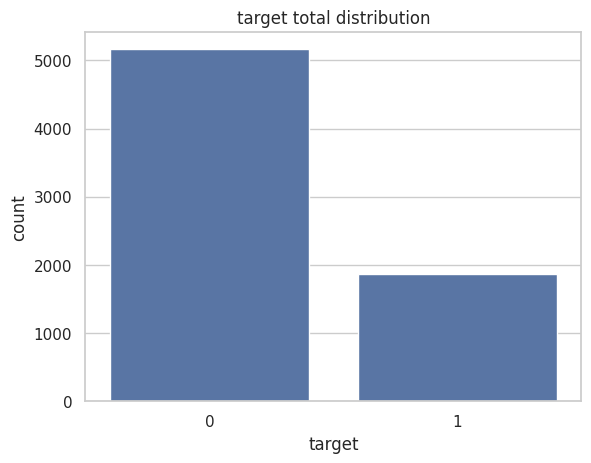

In [40]:
# директория для сохранения картинок
ASSETS_DIR = 'assets'

# установка названия колонки для агрегации
x = "target"

# подсчёт количества каждого уникального значения в колонке и сброс индекса для последующей визуализации
target_agg = df['target'].value_counts().reset_index()

# создание столбчатой диаграммы для визуализации распределения целевой переменной
sns.barplot(data=target_agg, x=x, y='count')

# установка заголовка графика
plt.title(f"{x} total distribution")

# сохранение графика в файл
plt.savefig(os.path.join(ASSETS_DIR, "target_count"))

In [41]:
df[x].value_counts().reset_index()

,target,count
0,0,5163
1,1,1869


### Влияние на таргет

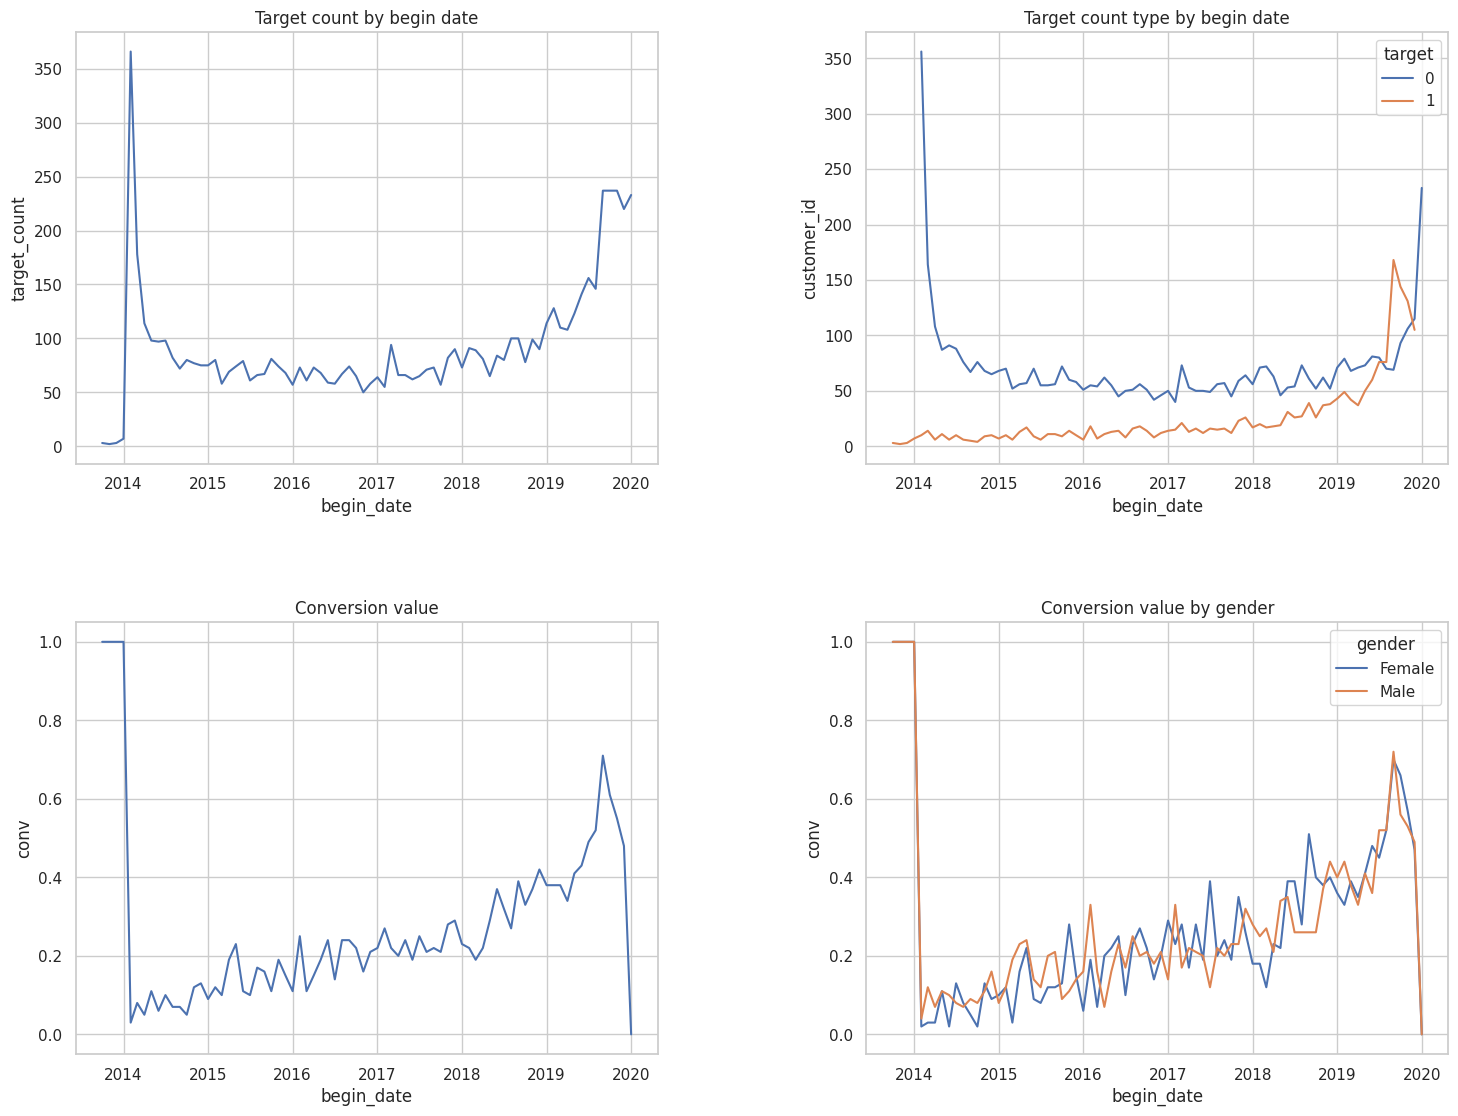

In [53]:
# установка переменных для анализа
x = "begin_date"
target = "target"

# определение статистики для агрегации
stat = ["count"]

# агрегация количества целей по датам начала с последующим сбросом индекса
target_agg_by_date = df[[x, target]].groupby([x]).agg(stat).reset_index()
# удаление мультиуровневости заголовков после агрегации и переименование для удобства
target_agg_by_date.columns = target_agg_by_date.columns.droplevel()
target_agg_by_date.columns = [x, "target_count"]

# подсчёт количества клиентов для каждого значения цели по датам
target_agg = df[[x, target, 'customer_id']].groupby([x, target]).count().reset_index()# расчёт суммы и количества для конверсии по датам
conversion_agg = df[[x, target]].groupby([x])['target'].agg(['sum', 'count']).reset_index()
# вычисление коэффициента конверсии и округление до двух знаков
conversion_agg['conv'] = (conversion_agg['sum'] / conversion_agg['count']).round(2)

# аналогичный расчет конверсии, но с дополнительным разделением по полу
conversion_agg_gender = df[[x, target, 'gender']].groupby([x, 'gender'])[target].agg(['sum', 'count']).reset_index()
conversion_agg_gender['conv'] = (conversion_agg_gender['sum'] / conversion_agg_gender['count']).round(2)

# инициализация фигуры для отображения нескольких графиков
fig, axs = plt.subplots(2, 2)
fig.tight_layout(pad=1.6)  # настройка отступов между подграфиками
fig.set_size_inches(16.5, 12.5, forward=True)  # установка размера фигуры

# визуализация общего количества целей по датам начала
sns.lineplot(data=target_agg_by_date, x=x, y="target_count", ax=axs[0, 0])
axs[0, 0].set_title("Target count by begin date")

# визуализация количества клиентов для каждого типа цели по датам
# ваш код здесь #
sns.lineplot(data=target_agg, x=x, y='customer_id', hue=target, ax=axs[0, 1])
axs[0, 1].set_title("Target count type by begin date")

# визуализация коэффициента конверсии по датам
# ваш код здесь #
sns.lineplot(data=conversion_agg, x=x, y="conv", ax=axs[1, 0])
axs[1, 0].set_title("Conversion value")

# визуализация коэффициента конверсии по датам с разделением по полу
# ваш код здесь #
sns.lineplot(data=conversion_agg_gender, x=x, y="conv", hue='gender', ax=axs[1, 1])
axs[1, 1].set_title("Conversion value by gender")

# сохранение визуализации в файл
plt.savefig(os.path.join(ASSETS_DIR, "target_by_date"))

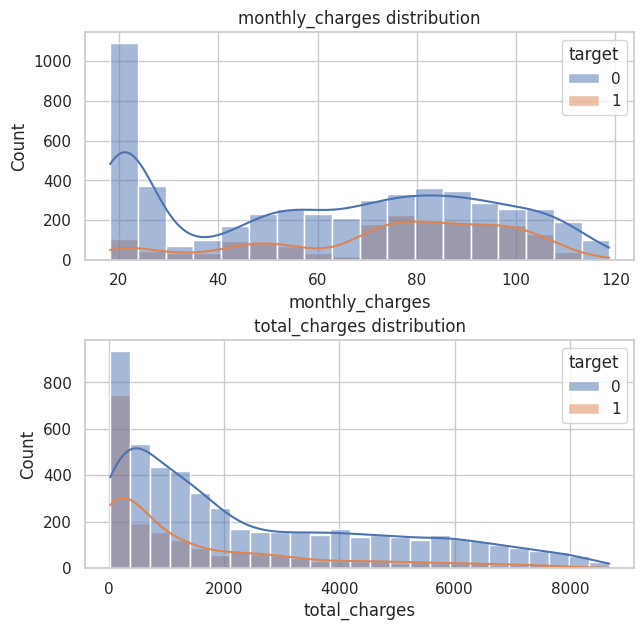

In [56]:
# определение списка столбцов с данными о платежах и целевой переменной
charges = ["monthly_charges", "total_charges"]
target = "target"

# инициализация фигуры для отображения гистограмм
fig, axs = plt.subplots(2, 1)
fig.tight_layout(pad=1.5)  # настройка отступов между подграфиками
fig.set_size_inches(6.5, 6.5, forward=True)  # установка размера фигуры

# визуализация распределения ежемесячных платежей с разделением по целевой переменной
# ваш код здесь #
sns.histplot(data=df, x=charges[0], hue=target, ax=axs[0], kde=True)
axs[0].set_title(f"{charges[0]} distribution")  # установка заголовка для гистограммы

# визуализация распределения общих платежей с разделением по целевой переменной
# ваш код здесь #
sns.histplot(data=df, x=charges[1], hue=target, ax=axs[1], kde=True)
axs[1].set_title(f"{charges[1]} distribution")  # Установка заголовка для второй гистограммы

# сохранение фигуры с гистограммами в файл
plt.savefig(os.path.join(ASSETS_DIR, "chargest_by_target_dist"))

In [8]:
TRACKING_SERVER_HOST = "127.0.0.1"
TRACKING_SERVER_PORT = 5000
ASSETS_DIR = "assets"

EXPERIMENT_NAME = "eda_churn_alexndem" # напишите название вашего эксперимента
RUN_NAME = "eda"

os.environ["MLFLOW_S3_ENDPOINT_URL"] = "https://storage.yandexcloud.net"
os.environ["AWS_ACCESS_KEY_ID"] = os.getenv("AWS_ACCESS_KEY_ID")
os.environ["AWS_SECRET_ACCESS_KEY"] = os.getenv("AWS_SECRET_ACCESS_KEY")

mlflow.set_tracking_uri(f"http://{TRACKING_SERVER_HOST}:{TRACKING_SERVER_PORT}")
mlflow.set_registry_uri(f"http://{TRACKING_SERVER_HOST}:{TRACKING_SERVER_PORT}")

experiment_id = mlflow.get_experiment_by_name(EXPERIMENT_NAME).experiment_id

with mlflow.start_run(run_name=RUN_NAME, experiment_id=experiment_id) as run:
    run_id = run.info.run_id

    mlflow.log_artifacts(ASSETS_DIR) 

In [9]:
run_id

'aa843b15ec5b4caba9a98fc21a314dda'